In [2]:
import pickle
import os
from rulu.bootstrap_CI_test import *
from rulu.normal_normal_model import get_samples
from rulu.utils import get_test_params, find_all_tests_in_same_category
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
import time

/Users/bryan.liu/.local/share/virtualenvs/ranking_under_lower_uncertainty-NLm1LOk1/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/bryan.liu/.local/share/virtualenvs/ranking_under_lower_uncertainty-NLm1LOk1/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def print_test_collection_result(test_collection: List[BootstrapCITest]) -> None:
    if test_collection is None or len(test_collection) == 0:
        print("There is nothing in the provided test collection.")
        return

    within_CI = [test.theoretical_quantity_in_sample_CI()
                 for test in test_collection]

    print(test_collection[0].test_name() +
          ": {}/{} ({}%) "
          .format(np.sum(within_CI), len(within_CI),
                  np.round(100.0 * np.sum(within_CI) / len(within_CI), 2)) +
          "of the tests have the theoretical quantity within the CI.")


def save_test_collection(test_collection: List[BootstrapCITest], in_dir: str = './output/') -> None:
    """
    Save given `test_collection` as a pickle file in `in_dir`
    :param test_collection: List of tests
    :param in_dir: Output directory
    :return: None
    """
    if test_collection is None or len(test_collection) == 0:
        return

    file_name = (in_dir + str(test_collection[0].__class__.__name__) +
                 "_" + str(int(time.time())) + ".pickle")
    pickle_file = open(file_name, 'wb')
    pickle.dump(test_collection, pickle_file)

    print("The test collection is saved at " + file_name)


def find_all_tests_in_same_category(test, in_dir='../output'):
    """
    Retrieve all tests in `in_dir` that is of the same type as the specified `test`
    """
    
    def get_tests_from_pickle_file(file_path):
        filehandler = open(file_path, 'rb')
        return pickle.load(filehandler)
    
    tests_pickle_fps = [
        os.path.join(in_dir, file)
        for file in os.listdir(in_dir) 
        if str(test.__class__.__name__) in file]
    
    return [test for tests in map(get_tests_from_pickle_file, tests_pickle_fps)
            for test in tests]

In [3]:
num_tests = 100
num_runs = 10000
BOOTSTRAP_BATCH_SIZE = 100
num_bootstrap_samples = 2000

In [4]:
# Prepare test collections
var_V_tests = []
cov_V1_V2_tests = []
var_D_tests = []

bootstrap_test_collections = [
    var_V_tests,
    cov_V1_V2_tests,
    var_D_tests
]

for num_test in range(0, num_tests):
    try:
        # Sample the parameters from a realistic parameter space
        params = get_test_params()
        N = int(params['N'])
        M = int(params['M'])
        mu_X = params['mu_X']
        mu_epsilon = params['mu_epsilon']
        sigma_sq_X = params['sigma_sq_X']
        sigma_sq_1 = params['sigma_sq_1']
        sigma_sq_2 = params['sigma_sq_2']
        r = params['r']
        s = params['s']

        # Prepare a test
        var_V_test = VarVCITest(sigma_sq_X, N, M, sigma_sq_1=sigma_sq_1)
        cov_V1_V2_test = CovV1V2CITest(sigma_sq_X, sigma_sq_1, sigma_sq_2, N, M)
        var_D_test = VarDCITest(sigma_sq_X, sigma_sq_1, sigma_sq_2, N, M)

        # Arrange the covariance tests IN THE SAME ORDER as that in the collections
        bootstrap_tests = [var_V_test,
                           cov_V1_V2_test,
                           var_D_test
                          ]
        
        # Get the initial samples
        print("Test {}/{} (N={}, M={}): calculating initial samples...    "
              .format(num_test + 1, num_tests, N, M),
              end='\r')
        
        samples = get_samples(num_runs, N, M, mu_X, mu_epsilon,
                              sigma_sq_X, sigma_sq_1, sigma_sq_2,
                              verbose=False, r=r, s=s)
        
        for test in bootstrap_tests:
            test.set_initial_samples(samples)
        
        # Bootstrap from the initial samples in batches
        for i in range(0, int(num_bootstrap_samples / BOOTSTRAP_BATCH_SIZE)):
            print("Test {}/{} (N={}, M={}): calculating bootstrap samples {}/{}...    "
                  .format(num_test + 1, num_tests, N, M,
                          i * BOOTSTRAP_BATCH_SIZE, num_bootstrap_samples),
                  end='\r')
            
            for test in bootstrap_tests:
                test.generate_bootstrap_samples(BOOTSTRAP_BATCH_SIZE)
        
        # Generate bootstrap samples that can't fit in a batch
        for test in bootstrap_tests:
                test.generate_bootstrap_samples(num_bootstrap_samples % BOOTSTRAP_BATCH_SIZE)

        # Once a test is completed (i.e. we collected enough covariate
        # samples), we added them to the corresponding, existing
        # collection of tests
        for (bootstrap_test, bootstrap_test_collection) in \
                [(bootstrap_tests[i], bootstrap_test_collections[i]) 
                 for i in range(0, len(bootstrap_tests))]:
            bootstrap_test_collection.append(bootstrap_test)
                        
        print("Test {}/{} (N={}, M={}): Done.                                         "
              .format(num_test + 1, num_tests, N, M))

    except KeyboardInterrupt:
        # Breaking the for loop is sufficient, as we want to
        # analyse the results accumulated so far
        break

# Print some statistics and save the test collections for future reference
# once we reached the number of experiments / process is interrupted
for bootstrap_test_collection in bootstrap_test_collections:
    try:
        print_test_collection_result(bootstrap_test_collection)
    except KeyboardInterrupt:
        print("{}: Skipped.".format(bootstrap_test_collection[0].test_name()))
    save_test_collection(bootstrap_test_collection)

Test 1/100 (N=14, M=7): Done.                                         
Test 2/100 (N=11, M=5): Done.                                         
Test 3/100 (N=178, M=45): Done.                                         
Test 4/100 (N=120, M=32): Done.                                         
Test 5/100 (N=19, M=6): Done.                                         
Test 6/100 (N=503, M=341): Done.                                         
Test 7/100 (N=2512, M=858): Done.                                         
Test 8/100 (N=220, M=164): Done.                                         
Test 9/100 (N=2642, M=1643): Done.                                         
Test 10/100 (N=309, M=76): Done.                                         
Test 11/100 (N=1511, M=595): Done.                                         
Test 12/100 (N=918, M=714): Done.                                         
Test 13/100 (N=36, M=17): Done.                                         
Test 14/100 (N=569, M=27): Done.            

In [7]:
for bootstrap_test_collection in bootstrap_test_collections:
    save_test_collection(bootstrap_test_collection, in_dir="./output/bootstrap_CI_tests/")

The test collection is saved at ./output/bootstrap_CI_tests/VarVCITest_1577960139.pickle
The test collection is saved at ./output/bootstrap_CI_tests/CovV1V2CITest_1577960141.pickle
The test collection is saved at ./output/bootstrap_CI_tests/VarDCITest_1577960145.pickle


In [5]:
theoretical_sample_percentile = [test.theoretical_quantity_sample_percentile() for test in examples]

In [ ]:
plt.hist(theoretical_sample_percentile, bins=range(0, 105, 5))
plt.xlim(0, 100)
plt.show()

In [3]:
cov_V1_V2_tests = find_all_tests_in_same_category(CovV1V2CITest(sigma_sq_1=0.5**2), 
                                                  in_dir='./output/bootstrap_CI_tests/')

for test in cov_V1_V2_tests:
    test.theoretical_quantity_cache = None
    
print_test_collection_result(cov_V1_V2_tests)

save_test_collection(cov_V1_V2_tests, in_dir="./output/bootstrap_CI_tests/")

Cov(V1, V2): 6/127 (4.72%) of the tests have the theoretical quantity within the CI.
The test collection is saved at ./output/bootstrap_CI_tests/CovV1V2CITest_1583301794.pickle


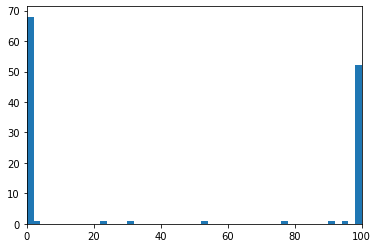

In [4]:
test_collection = cov_V1_V2_tests

theoretical_quantity_percentiles = [
    test.theoretical_quantity_sample_percentile()
    for test in test_collection]

plt.hist(theoretical_quantity_percentiles, bins=range(0, 102, 2))
plt.xlim(0, 100)
plt.show()

In [5]:
for test in cov_V1_V2_tests:
    if test.theoretical_quantity_below_sample_CI():
        print(test.N, test.M,  "    \t",
              np.round(test.sigma_sq_X, 3), 
              np.round(test.sigma_sq_1, 3), np.round(test.sigma_sq_2, 3), "\t",
              np.round(test.theoretical_quantity(), 3),
              np.round(test.sample_CI(), 4), "\t",
              np.round(test.theoretical_quantity() / test.sample_CI(), 3)
             )

1020 335     	 3.142 66.076 63.447 	 0.003 [0.003  0.0034] 	 [0.973 0.865]
149 38     	 1.542 34.282 1.963 	 0.007 [0.0132 0.0147] 	 [0.545 0.488]
169 25     	 43.773 55.153 24.531 	 0.431 [0.7378 0.7956] 	 [0.584 0.542]
83 9     	 1.139 25.699 21.215 	 0.014 [0.0145 0.0194] 	 [0.993 0.74 ]
811 560     	 3.441 18.412 8.016 	 0.003 [0.0044 0.0047] 	 [0.679 0.637]
832 46     	 1.969 19.522 4.019 	 0.003 [0.0056 0.0071] 	 [0.544 0.433]
14 5     	 5.627 5.275 2.562 	 0.415 [0.6631 0.707 ] 	 [0.625 0.586]
1561 464     	 2.674 83.763 10.262 	 0.001 [0.002  0.0023] 	 [0.728 0.652]
649 226     	 68.081 80.716 2.088 	 0.157 [0.1705 0.1811] 	 [0.923 0.869]
32 20     	 50.322 46.168 10.538 	 1.6 [1.9003 2.0108] 	 [0.842 0.796]
15 11     	 9.545 77.025 3.118 	 0.258 [0.6511 0.6913] 	 [0.397 0.374]
2341 1868     	 1.823 80.505 6.69 	 0.001 [0.0008 0.0008] 	 [0.792 0.745]
158 26     	 1.08 7.96 1.733 	 0.006 [0.0112 0.0127] 	 [0.576 0.509]
466 112     	 5.76 65.345 6.58 	 0.009 [0.0186 0.0205] 	 [0.